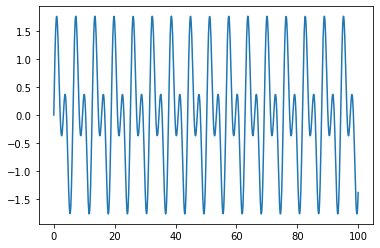

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim


# ====== Generating Dataset ====== #
num_data = 1000
t = np.linspace(0.0, 100.0, num_data)
y = np.sin(t) + np.sin(2*t) #+ np.sin(0.4*t)
e = np.random.normal(0, 0.1, num_data)
# y = y + e


seq_len = 10
X = []
Y_true = []
for i in range(len(t)-seq_len):
    X.append(y[i:i+seq_len])
    Y_true.append(y[i+seq_len])
    
X = np.array(X)
Y_true = np.array(Y_true)

#X = np.swapaxes(X,0,)
X = np.expand_dims(X, axis=2)
Y_true = np.expand_dims(Y_true, axis=-1)

plt.plot(t, y)


torch.Size([990, 1])


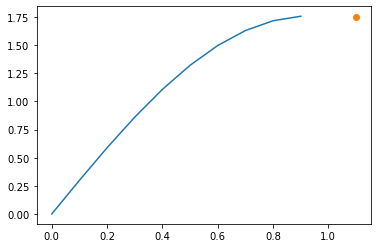

In [71]:
plt.plot(t[:10], X[0])
plt.plot(t[11], Y_true[0], 'o')
X.shape, Y_true.shape
a = torch.Tensor(Y_true[0]).float()
print(torch.Tensor(Y_true).float().shape)


In [72]:
import torch
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, batch_size): 
        super(RNN, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.batch_size = batch_size
        
        self.u = nn.Linear(self.input_dim, self.hid_dim, bias=False)
        self.w = nn.Linear(self.hid_dim, self.hid_dim, bias=False)
        self.v = nn.Linear(self.hid_dim, self.output_dim, bias=False)
        self.act = nn.Tanh()
        
        self.hidden = self.init_hidden()
        
    def init_hidden(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        return torch.zeros(batch_size, self.hid_dim)
    
    def forward(self, x):
        for seq_x in x:
            self.hidden = self.act(self.u(seq_x) + self.w(self.hidden))
            y = self.v(self.hidden)
        return y, self.hidden

In [91]:
model = RNN(1, 1, 50, 1)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)
epoch = 20
losses = []
for i in range(epoch):
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    model.hidden = model.init_hidden()
    
    for x, y_true in zip(X, Y_true):
        #Y_pred = []
        x = torch.Tensor(x).float()
        Y_pred, hidden = model(x)
        model.hidden = hidden
        y_true = torch.Tensor(y_true).float()

    loss = loss_fn(Y_pred.view(-1), y_true.view(-1))
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

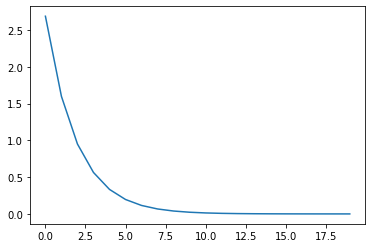

In [92]:
plt.plot(range(20), losses)

((200, 10, 1), (200, 1))

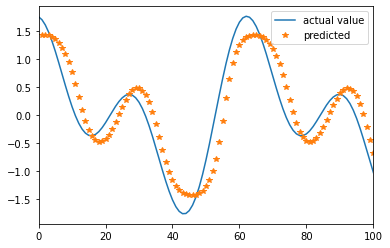

In [98]:
x_test = X

list_y_pred = []

model.eval()
with torch.no_grad():
    model.hidden = model.init_hidden(batch_size=1)

    for x in x_test:
        x = torch.Tensor(x).float()
        y_pred, hidden = model(x)
        model.hidden = hidden
        list_y_pred.append(y_pred.view(-1).item())
    
    #200, 1
    list_y_pred = np.array(list_y_pred)

plt.plot(Y_true, label='actual value')
plt.plot(list(range(1,len(list_y_pred)+1)), list_y_pred, '*', label='predicted')
plt.xlim(0, 100)
plt.legend()
